# Lab 4: Lab 4: Tuning your autograd training loop for Fashion-MNIST
### Author: Nigel Nelson
### Course: CS-3450
### Date: 4/3/2022
---
---

### Imports:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import warnings
import os.path
import nvidia_smi

---
---
## Provided Code:

In [2]:
EPOCHS = 50

# For simple regression problem
TRAINING_POINTS = 1000

# For fashion-MNIST and similar problems
DATA_ROOT = '/../../data/cs3450/data/'
FASHION_MNIST_TRAINING = '/../../data/cs3450/data/fashion_mnist_flattened_training.npz'
FASHION_MNIST_TESTING = '/../../data/cs3450/data/fashion_mnist_flattened_testing.npz'
CIFAR10_TRAINING = '/../../data/cs3450/data/cifar10_flattened_training.npz'
CIFAR10_TESTING = '/../../data/cs3450/data/cifar10_flattened_testing.npz'
CIFAR100_TRAINING = '/../../data/cs3450/data/cifar100_flattened_training.npz'
CIFAR100_TESTING = '/../../data/cs3450/data/cifar100_flattened_testing.npz'


In [3]:
def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu().
       https://d2l.ai/chapter_deep-learning-computation/use-gpu.html
    """
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
DEVICE=try_gpu()
DEVICE

device(type='cuda', index=0)

In [4]:
def create_linear_training_data():
    """
    This method simply rotates points in a 2D space.
    Be sure to use L2 regression in the place of the final softmax layer before testing on this
    data!
    :return: (x,y) the dataset. x is a numpy array where columns are training samples and
             y is a numpy array where columns are one-hot labels for the training sample.
    """
    x = torch.randn((2, TRAINING_POINTS))
    x1 = x[0:1, :].clone()
    x2 = x[1:2, :]
    y = torch.cat((-x2, x1), axis=0)
    return x, y


def create_folded_training_data():
    """
    This method introduces a single non-linear fold into the sort of data created by create_linear_training_data. Be sure to REMOVE the final softmax layer before testing on this data!
    Be sure to use L2 regression in the place of the final softmax layer before testing on this
    data!
    :return: (x,y) the dataset. x is a numpy array where columns are training samples and
             y is a numpy array where columns are one-hot labels for the training sample.
    """
    x = torch.randn((2, TRAINING_POINTS))
    x1 = x[0:1, :].clone()
    x2 = x[1:2, :]
    x2 *= 2 * ((x2 > 0).float() - 0.5)
    y = torch.cat((-x2, x1), axis=0)
    return x, y


def create_square():
    """
    This is the square example that we looked at in class.
    insideness is true if the points are inside the square.
    :return: (points, insideness) the dataset. points is a 2xN array of points and insideness is true if the point is inside the square.
    """
    win_x = [2,2,3,3]
    win_y = [1,2,2,1]
    win = torch.tensor([win_x,win_y],dtype=torch.float32)
    win_rot = torch.cat((win[:,1:],win[:,0:1]),axis=1)
    t = win_rot - win # edges tangent along side of poly
    rotation = torch.tensor([[0, 1],[-1,0]],dtype=torch.float32)
    normal = rotation @ t # normal vectors to each side of poly
        # torch.matmul(rotation,t) # Same thing

    points = torch.rand((2,2000),dtype = torch.float32)
    points = 4*points

    vectors = points[:,np.newaxis,:] - win[:,:,np.newaxis] # reshape to fill origin
    insideness = (normal[:,:,np.newaxis] * vectors).sum(axis=0)
    insideness = insideness.T
    insideness = insideness > 0
    insideness = insideness.all(axis=1)
    return points, insideness

In [5]:
def load_dataset_flattened(train=True,dataset='Fashion-MNIST',download=False):
    """
    :param train: True for training, False for testing
    :param dataset: 'Fashion-MNIST', 'CIFAR-10', or 'CIFAR-100'
    :param download: True to download. Keep to false afterwords to avoid unneeded downloads.
    :return: (x,y) the dataset. x is a numpy array where columns are training samples and
             y is a numpy array where columns are one-hot labels for the training sample.
    """
    if dataset == 'Fashion-MNIST':
        if train:
            path = FASHION_MNIST_TRAINING
        else:
            path = FASHION_MNIST_TESTING
        num_labels = 10
    elif dataset == 'CIFAR-10':
        if train:
            path = CIFAR10_TRAINING
        else:
            path = CIFAR10_TESTING
        num_labels = 10
    elif dataset == 'CIFAR-100':
        if train:
            path = CIFAR100_TRAINING
        else:
            path = CIFAR100_TESTING
        num_labels = 100
    else:
        raise ValueError('Unknown dataset: '+str(dataset))

    if os.path.isfile(path):
        print('Loading cached flattened data for',dataset,'training' if train else 'testing')
        data = np.load(path)
        x = torch.tensor(data['x'],dtype=torch.float32)
        y = torch.tensor(data['y'],dtype=torch.float32)
        pass
    else:
        class ToTorch(object):
            """Like ToTensor, only to a numpy array"""

            def __call__(self, pic):
                return torchvision.transforms.functional.to_tensor(pic)

        if dataset == 'Fashion-MNIST':
            data = torchvision.datasets.FashionMNIST(
                root=DATA_ROOT, train=train, transform=ToTorch(), download=download)
        elif dataset == 'CIFAR-10':
            data = torchvision.datasets.CIFAR10(
                root=DATA_ROOT, train=train, transform=ToTorch(), download=download)
        elif dataset == 'CIFAR-100':
            data = torchvision.datasets.CIFAR100(
                root=DATA_ROOT, train=train, transform=ToTorch(), download=download)
        else:
            raise ValueError('This code should be unreachable because of a previous check.')
        x = torch.zeros((len(data[0][0].flatten()), len(data)),dtype=torch.float32)
        for index, image in enumerate(data):
            x[:, index] = data[index][0].flatten()
        labels = torch.tensor([sample[1] for sample in data])
        y = torch.zeros((num_labels, len(labels)), dtype=torch.float32)
        y[labels, torch.arange(len(labels))] = 1
        np.savez(path, x=x.detach().numpy(), y=y.detach().numpy())
    return x, y

In [6]:
# dataset = 'Fashion-MNIST'
dataset = 'CIFAR-10'
# dataset = 'CIFAR-100'

#x_train, y_train = create_linear_training_data()
#x_train, y_train = create_folded_training_data()
#points_train, insideness_train = create_square()
x_train, y_train = load_dataset_flattened(train=True, dataset=dataset, download=False)

# Move selected datasets to GPU
x_train = x_train.to(DEVICE)
y_train = y_train.to(DEVICE)

Loading cached flattened data for CIFAR-10 training


In [7]:
x_train

torch.Size([3072, 50000])

In [8]:
y_train

torch.Size([10, 50000])

In [9]:
#x_test, y_test = create_linear_training_data()
x_test, y_test = load_dataset_flattened(train=False, dataset=dataset, download=False)

# Move the selected datasets to the GPU
x_test = x_test.to(DEVICE)
y_test = y_test.to(DEVICE)

Loading cached flattened data for CIFAR-10 testing


In [10]:
x_test

tensor([[0.6196, 0.9216, 0.6196,  ..., 0.0784, 0.0980, 0.2863],
        [0.6235, 0.9059, 0.6196,  ..., 0.0745, 0.0588, 0.3843],
        [0.6471, 0.9098, 0.5451,  ..., 0.0588, 0.0902, 0.3882],
        ...,
        [0.4863, 0.6980, 0.0314,  ..., 0.1961, 0.3137, 0.3686],
        [0.5059, 0.7490, 0.0118,  ..., 0.2078, 0.3176, 0.2275],
        [0.4314, 0.7804, 0.0275,  ..., 0.1843, 0.3137, 0.1020]],
       device='cuda:0')

In [11]:
y_test

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

---
---
### Backpropagation with Autograd:

In [29]:
class Layer:
    """
    Responsible for modeling a single matrix in an Input
    """
    def __init__(self, output_shape):
        """
        :param output_shape (tuple): the shape of the output array.  When this is a single number,
        it gives the number of output neurons. When this is an array, it gives the dimensions 
        of the array of output neurons.
        """
        if not isinstance(output_shape, tuple):
            output_shape = (output_shape,)
            
        self.output_shape = output_shape
        
        
class Input(Layer):
    """
    Responsible for modeling a single matrix in a Linear layer
    """
    def __init__(self, output_shape):
        """
        :param output_shape (tuple): the shape of the output array. Passed to parent's initializer
        """
        Layer.__init__(self, output_shape)

    def set(self, value):
        """
        :param value: Value of the matrix. If the shape of the matrix doesn't meet the expectations
        of the Input instance, an assertion error is raised
        """
        assert self.output_shape == value.shape
        self.output = value
        
    def forward(self):
        """This layer's values do not change during forward propagation."""
        pass


class LinearReLU(Layer):
    """
    Class responsible for modeling a Linear Layer with a ReLU activation function
    """
    def __init__(self, x, W, b):
        """
        :param x: The input matrix of the layer
        :param W: The weight matrix of the layer
        :param b: The biase matrix of the layer. If this doesn't equal the Input's expected shape,
        an assertion error is raised
        """
        Layer.__init__(self, b.output_shape) # TODO: Pass along any arguments to the parent's initializer here.
        self.x = x
        self.W = W
        self.b = b
        
    def ReLU(self, x):
        """
        :param x: The values to perform the ReLU activation function on
        """
        return x * (x > 0)
    
    def forward(self):
        """
        Sets the layer's output based on the outputs of the layers that feed into it after applying the
        ReLU activation function
        """
        self.output = self.ReLU((self.W.output @ self.x.output) + self.b.output)
        self.output.retain_grad()
   

class Linear(Layer):
    """
    Class responsible for modeling a Linear Layer without an activation function
    """
    def __init__(self, x, W, b):
        """
        :param x: The input matrix of the layer
        :param W: The weight matrix of the layer
        :param b: The biase matrix of the layer. If this doesn't equal the Input's expected shape,
        an assertion error is raised
        """
        Layer.__init__(self, b.output_shape) # TODO: Pass along any arguments to the parent's initializer here.
        self.x = x
        self.W = W
        self.b = b
    

    def forward(self):
        """
        Sets the layer's output based on the outputs of the layers that feed into it
        """
        self.output = (self.W.output @ self.x.output) + self.b.output
        self.output.retain_grad()
        
class Network:
    """
    Class responsible for defining the behavior of a simple Neural Network with a single hidden layer
    """
    def __init__(self, input_rows, num_hidden_nodes, num_classes, dtype=torch.float32, device=torch.device('cuda:0')):
        """
        :param input_rows: The number of rows expected in the input of the network
        :param num_hidden_nodes: The number of nodes in the hidden layer desired
        :param num_classes: The number of expected outputs
        :param dtype: The data type to be used with the PyTorch tensors
        :param device: The device desired to be used with the PyTorch tensors
        """
        # Define weights and bias matrices for input -> hidden layer
        W = torch.rand((num_hidden_nodes, input_rows), dtype=dtype, device=device, requires_grad=True)
        W.data *= 0.1
        b1 = torch.zeros((num_hidden_nodes,1), dtype=dtype, device=device, requires_grad=True)
        
        # Define weights and bias matrices for hidden layer -> ouput
        M = torch.rand((num_classes ,num_hidden_nodes), dtype=dtype, device=device, requires_grad=True)
        M.data *= 0.1
        b2 = torch.zeros((num_classes, 1), dtype=dtype, device=device, requires_grad=True)

        # Create Input instances for all matrices
        W_layer = Input((num_hidden_nodes, input_rows))
        W_layer.set(W)
        b1_layer = Input((num_hidden_nodes,1))
        b1_layer.set(b1)
        M_layer = Input((num_classes,num_hidden_nodes))
        M_layer.set(M)
        b2_layer = Input((num_classes,1))
        b2_layer.set(b2)

        # Create 1st layer with ReLU activation function
        x1_layer = Input(x_train.shape[0])
        linear_layer1 = LinearReLU(x1_layer, W_layer, b1_layer)
        
        # Create 2nd layer without activation function
        x2_layer = Input(b1_layer.output.shape[0])
        linear_layer2 = Linear(x2_layer, M_layer, b2_layer)
        
        # Assign class variables
        self.layer1 = linear_layer1
        self.layer2 = linear_layer2
    
    
    def L2(self, actual, predicted):
        """
        Returns the L2 loss of the supplied args
        :param actual: The true values
        :param predicted: The predicted values
        """
        return ((actual - predicted)**2).mean()
    
    def softmax(self, X):
        """
        Responsible for calculating the softmax output of a provided network layer
        :param X: The output of a provided network layer
        """
        e = torch.exp(X - torch.max(X))
        return e / e.sum()
    
    def cross_entropy(self, actual, predicted):
        """
        Calculates the cross entropy loss for predicted vs. the actual values
        :param actual: The true values
        :param predicted: The predicted values
        """
        soft_max = self.softmax(predicted)
        #Small constant such that soft_max + epsilon is never 0
        epsilon = 1*10**-7
        L = (actual * torch.log(soft_max + epsilon)).sum()
        return -1*L, soft_max
        
    def train(self, x_train, y_train, num_epochs, learning_rate, reg_const, batch_size):
        """
        Method responsible for training the Neural Network
        :param x_train: The X training data
        :param y_train: The y training labels
        :param num_epochs: Number of epochs to train for
        :param learning_rate: The rate at which parameters are adjusted
        :param reg_const: The regularization constant that scales the regularization term
        :param batch_size: The batch size used for training
        """
        # Adjust the x matrices according to the batch size
        self.layer1.x = Input((x_train.shape[0], batch_size))
        self.layer2.x = Input((self.layer1.b.output.shape[0], batch_size))
        
        accuracies = []
        
        for epoch in range(num_epochs):
            num_correct = 0
            num_samples = 0
            for i in range(x_train.shape[1]//batch_size):
                
                num_samples += batch_size
                
                # Get the correct locations to reference in the training and testing sets
                start_idx = i*batch_size
                end_idx = i*batch_size + batch_size

                # Populate the x matrix with the training samples in this batch
                self.layer1.x.set(x_train[:, start_idx : end_idx].reshape(x_train.shape[0], batch_size))
                self.layer1.forward()
                self.layer2.x.set(self.layer1.output)
                self.layer2.forward()
                
                true_labels = (y_train[:, start_idx : end_idx]).reshape(y_train.shape[0], batch_size)

                # Calculate the Cross entropy loss using the output of layer 2 and the associated samples in
                # y_train
                loss, soft_max = self.cross_entropy(true_labels, self.layer2.output)
                
                # Calculate the number of correct predictions the network made
                num_correct += (torch.argmax(true_labels, dim=0) == torch.argmax(soft_max, dim=0)).sum().item()
                accuracy = num_correct / num_samples
                
                # Calculate the regularization term
                s1 = (self.layer1.W.output**2).sum()
                s2 = (self.layer2.W.output**2).sum()
                reg = reg_const*(s1 + s2)

                # Calculate the final cost term
                cost = loss + reg

                # Compute backpropagation with Autograd
                cost.backward()
            
                # Used to update parameters inplace
                with torch.no_grad():

                    # Adjust parameters according to gradients and the learning rate
                    self.layer1.W.output -= learning_rate * self.layer1.W.output.grad
                    self.layer1.b.output -= learning_rate * self.layer1.b.output.grad
                    self.layer2.W.output -= learning_rate * self.layer2.W.output.grad
                    self.layer2.b.output -= learning_rate * self.layer2.b.output.grad

                    # Zero the gradients
                    self.layer1.W.output.grad.zero_()
                    self.layer1.b.output.grad.zero_()
                    self.layer2.W.output.grad.zero_()
                    self.layer2.b.output.grad.zero_()
                    
            print(f'Epoch #{epoch + 1} Accuracy: {accuracy}, Loss: {loss.item()}')
            accuracies.append(accuracy)
            
            # Get GPU utilization rates
            nvidia_smi.nvmlInit()
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
            utilization = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
            print(f'gpu-usage: {utilization.gpu}%, gpu-mem-usage: {utilization.memory}%')
            
        return accuracies
    
    def test(self, x_test, y_test):
        """
        Method responsible for testing the Neural Network after it has been trained
        :param x_train: The X training data
        :param y_train: The training labels
        """
        # Recalibrate the 1st x layer according to the shape of the testing data
        self.layer1.x = Input(x_test.shape)
        self.layer1.x.set(x_test)
        
        self.layer1.forward()
        
        # Recalibrate the 2nd x layer according to the shape of the output of the 1st layer
        self.layer2.x = Input(self.layer1.output.shape)
        self.layer2.x.set(self.layer1.output)

        self.layer2.forward()
        
        true_labels = torch.argmax(y_test, dim=0)
        predicted = torch.argmax(self.softmax(self.layer2.output), dim=0)
        
        num_correct = (predicted == true_labels).sum().item()
        total_samples = y_test.shape[1]
        accuracy = num_correct / total_samples
    
        print(f'Testing Accuracy: {accuracy}')
        

## Training the Network:

In [31]:
input_rows = 3072
num_hidden_nodes = 24
num_epochs = 30
learning_rate = .001
reg_const = 0
batch_size = 4
num_classes = 10

print(f'Input rows: {input_rows}')
print(f'Num hidden nodes: {num_hidden_nodes}')
print(f'Epochs: {num_epochs}')
print(f'Learning Rate: {learning_rate}')
print(f'Reg_const: {reg_const}')
print(f'Batch size: {batch_size}')
print()

network = Network(input_rows, num_hidden_nodes, num_classes)
%time accuracies = network.train(x_train, y_train, num_epochs, learning_rate, reg_const, batch_size)
network.test(x_test, y_test)

Input rows: 3072
Num hidden nodes: 24
Epochs: 30
Learning Rate: 0.001
Reg_const: 0
Batch size: 4

Epoch #1 Accuracy: 0.09724, Loss: 64.47238159179688
gpu-usage: 23%, gpu-mem-usage: 0%
Epoch #2 Accuracy: 0.09894, Loss: 64.47238159179688
gpu-usage: 18%, gpu-mem-usage: 0%
Epoch #3 Accuracy: 0.09966, Loss: 48.354366302490234
gpu-usage: 18%, gpu-mem-usage: 0%
Epoch #4 Accuracy: 0.10008, Loss: 64.47238159179688
gpu-usage: 19%, gpu-mem-usage: 0%
Epoch #5 Accuracy: 0.1, Loss: 64.47238159179688
gpu-usage: 19%, gpu-mem-usage: 0%
Epoch #6 Accuracy: 0.1, Loss: 64.47238159179688
gpu-usage: 19%, gpu-mem-usage: 0%
Epoch #7 Accuracy: 0.1, Loss: 64.47238159179688
gpu-usage: 22%, gpu-mem-usage: 0%
Epoch #8 Accuracy: 0.1, Loss: 64.47238159179688
gpu-usage: 19%, gpu-mem-usage: 0%
Epoch #9 Accuracy: 0.1, Loss: 64.47238159179688
gpu-usage: 19%, gpu-mem-usage: 0%
Epoch #10 Accuracy: 0.1, Loss: 64.47238159179688
gpu-usage: 19%, gpu-mem-usage: 0%
Epoch #11 Accuracy: 0.1, Loss: 64.47238159179688
gpu-usage: 19%,

## Predictions and Records of Network Tuning for Fashion-MNIST:

| Experiment Number | Learning Rate | Batch Size | Epochs | Regularization Constant | Hidden Nodes | Parameters | Estimated Runtime | Actual Runtime | Estimated Memory Usage | GPU usage | Number layers | Training Accuracy | Testing Accuracy |
| ----------------- | ------------- | ---------- | ------ | ----------------------- | ------------ | ---------- | ----------------- | -------------- | ---------------------- | --------- | ------------- | ----------------- | ---------------- |
| 1                 | 0.001         | 1          | 12     | 0                       | 24           | 38,180     | N/A               | 30min 48s      | 152.72 kB              | 18%       | 1             | 0.87555           | 0.8574           |
| 2                 | 0.001         | 4          | 20     | 0                       | 24           | 38,180     | 11min 30s         | 13min 6s       | 152.72 kB              | 20%       | 1             | 0.87995           | 0.8593           |
| 3                 | 0.01          | 4          | 20     | 0                       | 24           | 38,180     | 13min             | 13min 1s       | 152.72 kB              | 20%       | 1             | 0.86957           | 0.8452           |
| 4                 | 0.001         | 4          | 20     | 0                       | 48           | 76,340     | 13min             | 13min 47s      | 305.36 kB              | 21%       | 1             | 0.88975           | 0.8703           |
| 5                 | 0.001         | 4          | 20     | 0                       | 128          | 203,540    | 13min             | 13min 18s      | 814.16 kB              | 22%       | 1             | 0.89756           | 0.8747           |
| 6                 | 0.001         | 16         | 30     | 0                       | 128          | 203,540    | 6min 30s          | 4min 28s       | 814.16 kB              | 26%       | 1             | 0.9088            | 0.8809           |
| 7                 | 0.001         | 16         | 60     | 0                       | 128          | 203,540    | 9min              | 10min 18s      | 814.16 kB              | 26%       | 1             | 0.93446           | 0.8887           |
| 8                 | 0.001         | 16         | 60     | 0                       | 256          | 407,060    | 10min             | 10min 22s      | 1.62 mB                | 26%       | 1             | 0.93443           | 0.8875           |
| 9                 | 0.001         | 32         | 60     | 0                       | 256          | 407,060    | 5min              | 5min 18s       | 1.62 mB                | 26%       | 1             | 0.90865           | 0.8763           |
| 10                | 0.001             | 64         | 120    | 0.001                   | 256          | 407,060    | 5min              | 5min 17s       | 1.62 mB                | 30%       | 1             | 0.93811           | 0.8873           |

## Justification for Experiments:

1. The hyperparameters for the first training session were chosen based on trial and error from the early stages of this lab when my network was still reluctant to learn. I chose a batch size of 1 to keep debugging simple, a learning rate of 0.001 as this was the learning rate I found allowed my network to learn at a reasonable rate, and 24 hidden nodes as I learned early on that using more than 100 made it very difficult for my model to learn.
2. After the first training session, I wanted to increase the efficiency of the training so I increased my batch size to 4. With this change I knew that this would mean my network would have its parameters updated 1/4 as many times as the first run, so to increase the number of opportunities to learn I decided to train for 20 epochs as it seemed like a large enough time train, but not too large to where training would take an hour or more.
3. With the benefit seen in accuracy and GPU usage from increasing the training epochs and batch size, I was curious to see if increasing the learning rate would allow my network to learn more at a faster pace. Following the learning rate conventions I've been taught at MSOE, I scaled my learning rate by a factor of 10 and set it to 0.01.
4. After learning that a larger learning rate had a negative impact on my network's performance, I returned the learning rate to my previous rate of 0.001. However, with the intuition that doubling the number of hidden nodes in my hidden layer would double the amount of information my network could store to properly learn the nuances of the dataset, I set the number of hidden nodes to 48 to see if this would increase the accuracy of my network.
5. From experiment #4, I saw that there may be a positive correlation with the number of hidden nodes and the accuracy of the network, so to again test my intuition expressed in the previous experiment's justification, I doubled the number of hidden nodes to 128.
6. After seeing a benefit in the accuracy of my model with previous hyperparameter adjustments, I was now interested to increase my GPU utilization as 20% usage seemed quite inefficient. Knowing that increasing the batch size would allow for greater parallelization, which would in turn increase the amount of work to be done by the GPU, I increased the batch size by a factor of 4 to 16. With 60,000 samples in an epoch, and a batch size of 4, my network was adjusting its parameters 300,000 times in my previous training sessions, however, with a batch size of 16, my network would now only update its hyperparameters 75,000 times. To allow my network more opportunities to learn without having too long of a training time, I increased the number of epochs by 10 to give my network an additional 37,500 opportunities to update its parameters.
7. With a slight increase seen in my network with the increased batch size and number of epochs, I wanted to see if doubling the number of opportunities for my network to adjust its parameters would have a profound impact on the resulting accuracy of the model. So, I set the number of epochs to 60 epochs, and with a batch size of 16, I gave my network an additional 112,500 opportunities to adjust its parameters.
8. Once again I was interested to see if increasing the number of hidden nodes would allow my network to learn more intricate nuances in the Fashion-MNIST dataset. With this in mind, I doubled the number of hidden nodes to 256 so that in theory, I would double the amount of information that my network could store on the dataset's patterns.
9. With low GPU usage, I knew that increasing the batch size would allow for a higher degree of parallelization, which would take advantage of the GPU's resources. So, in the hopes that doubling the batch size would double the amount of GPU usage, I set the batch size to 32.
10. After never using regularization, I was curious to see how this would impact the performance of the network, so based on successful trials in lab 3, I set the regularization constant to 0.001. In addition, I was still not satisfied with my low GPU usage, so I again doubled the batch size to 64 to hopefully increase my GPU usage. Lastly, to offset the fact that my network would now have half the opportunities to update its parameters, I doubled the number of epochs I would train for to give my network the same number opportunities to update its parameters as in the previous experiment.

## Predictions and Records of Network Tuning for CIFAR-10:

| Experiment Number | Learning Rate | Batch Size | Epochs | Regularization Constant | Hidden Nodes | Parameters | Estimated Runtime | Actual Runtime | Estimated Memory Usage | GPU usage | Number layers | Training Accuracy | Testing Accuracy |
| ----------------- | ------------- | ---------- | ------ | ----------------------- | ------------ | ---------- | ----------------- | -------------- | ---------------------- | --------- | ------------- | ----------------- | ---------------- |
| 1                 | 0.001         | 4          | 30     | 0                       | 12           | 74,132     | N/A               | 17min 45s      | 296.528 kB             | 18%       | 1             | 0.4404            | 0.4153           |
| 2                 | 0.001         | 4          | 30     | 0                       | 24           | 148,004    | 18min             | 18min 15s      |  592.016 kB            | 19%       | 1             | 0.472            | 0.4549           |
| 3                 | 0.001         | 4          | 30     | 0                       | 128          | 789,268    | 18min 30s         | 18min 26s      |  3.157072 mB           | 22%       | 1             | 0.1261            | 0.0999           |
| 4                 | 0.001         | 4          | 30     | 0                       | 48           | 295,988    | 18min             | 18min 6s       |  1.183952 mB           | 21%       | 1             | 0.44126           | 0.4355           |
| 5                 | 0.001         | 8          | 60     | 0                       | 48           | 295,988    | 18min             | 18min 24s      |  1.183952 mB           | 20%       | 1             | 0.45812           | 0.4344           |
| 6                 | 0.001         | 8          | 60     | 0                       | 64           | 394,644    | 18min 30s         | 18min 30s      |  1.578576 mB           | 21%       | 1             | 0.42108           | 0.4156           |
| 7                 | 0.001         | 16         | 120    | 0                       | 64           | 394,644    | 18min 30s         | 18min 44s      |  1.578576 mB           | 20%       | 1             | 0.40286           | 0.4043           |
| 8                 | 0.005         | 16         | 120    | 0                       | 48           | 295,988    | 18min 30s         | 18min 7s       |  1.183952 mB           | 20%       | 1             | 0.1006            | 0.0986           |
| 9                 | 0.001         | 32         | 240    | 0                       | 48           | 295,988    | 18min             | 18min 26s      |  1.183952 mB           | 20%       | 1             | 0.48897           | 0.4213           |
| 10                | 0.0001        | 32         | 240    | 0.001                   | 128          | 789,268    | 18 30s            | 18min 19s      |  3.157072 mB           | 23%       | 1             | 0.10113           | 0.1              |

## Training Curve for Most Accurate Hyperparameters on CIFAR-10:

Text(0.5, 1.0, 'Training Accuracy vs. Epoch #')

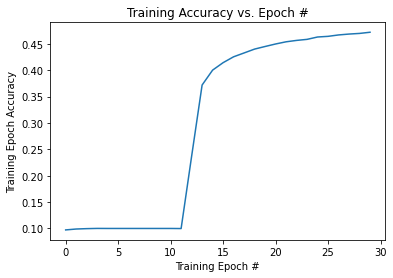

In [39]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), accuracies)
plt.xlabel('Training Epoch #')
plt.ylabel('Training Epoch Accuracy')
plt.title('Training Accuracy vs. Epoch #')

## Discussion:
- From the experiments I ran in this lab, I learned many lessons about tuning the hyperparameters of a neural network. The most general lesson that I learned, is that a good rule of thumb to remember is that just about every hyperparameter has a parabolic relationship with the accuracy of the network. This means that while increasing a hyperparameter may in turn cause higher network accuracy, eventually increases in this same hyperparameter will cease to improve the accuracy of the network, and will even likely decrease the accuracy instead. More specifically, I learned that having too many hidden nodes makes it very difficult for a network to train, but having too few starves the model of complexity that allows for greater accuracy. In addition, I learned increasing the batch size will general increase the amount of GPU usage, likely due to the increased degree of parallelization. I also learned that while increasing epochs does intuitively give the network more opportunities to learn and thereby increase the accuracy of the model, it also gives the network more opportunities to go beyond generalizing the dataset and instead begin to memorize the dataset and overfit. Lastly, I learned that batch size and the number of training epochs are essentially linearly correlated with training time, where doubling the epochs will double the training time and doubling batch size will halve the training time.
- Using these lessons that were learned through trial and error in this lab, I was ultimately able to achieve a maximum testing accuracy of on Fashion-MNIST of **0.8887**. This accuracy was achieved by training for 60 epochs, with a learning rate of 0.001, a batch size of 16, no regularization, and 128 nodes in a single hidden layer. In addition, I was able to achieve a maximum accuracy of **0.4549** on the CIFAR-10 dataset. This was accomplished by training for 30 epochs, with a learning rate of 0.001, a batch size of 4, no regularization, and 24 nodes in a single hidden layer.